# Chapter 06. Model Monitoring

## 6.1. Enable Data Capture for a Model Endpoint
---

In [1]:
%cd /root/sagemaker-course/notebooks/

/root/sagemaker-course/notebooks


In [2]:
import time

import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role, model

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 70)

# S3 bucket information
BUCKET = 'sagemaker-course-20200812'
PREFIX = 'churn'
LOCAL_DATA_DIRECTORY = f'../data/{PREFIX}'
print(f"Artifacts will be written to s3://{BUCKET}/{PREFIX}")

# Session variables we'll use throughout the notebook
sagemaker_session = sagemaker.Session()
boto_session = sagemaker_session.boto_session
sagemaker_client = boto_session.client('sagemaker')
role = get_execution_role()
print(f'Role ARN: {role}')

Artifacts will be written to s3://sagemaker-course-20200812/churn
Role ARN: arn:aws:iam::209970524256:role/service-role/AmazonSageMaker-ExecutionRole-20200618T144956


In [3]:
model_data = 's3://sagemaker-course-20200812/churn/builtin-xgboost-2020-08-12-12-05-52-988/output/model.tar.gz'
image_uri = '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

churn_model = model.Model(model_data=model_data,
                          image_uri=image_uri,
                          role=role,
                          sagemaker_session=sagemaker_session)

In [4]:
from sagemaker import model_monitor, predictor

In [5]:
captured_data_s3_uri = f's3://{BUCKET}/{PREFIX}/model-monitor/data-capture'
print(f'Captured data stored in bucket: {captured_data_s3_uri}')

data_capture_config = model_monitor.DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=captured_data_s3_uri,
    sagemaker_session=sagemaker_session)

Captured data stored in bucket: s3://sagemaker-course-20200812/churn/model-monitor/data-capture


In [6]:
churn_model.deploy(initial_instance_count=1, 
                   instance_type='ml.t2.medium',
                   data_capture_config=data_capture_config)

-----------------!

In [7]:
print(churn_model.name)
print(churn_model.endpoint_name)

sagemaker-xgboost-2020-08-14-12-26-58-745
sagemaker-xgboost-2020-08-14-12-26-59-139


In [11]:
churn_predictor = predictor.Predictor(
    endpoint_name=churn_model.endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer = sagemaker.serializers.CSVSerializer())

In [12]:
!head -3 ../data/churn/test_sample.csv

186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55
132,25,113.2,96,269.9,107,229.1,87,7.1,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
112,17,183.2,95,252.8,125,156.7,95,9.7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1


In [13]:
print("Sending test traffic to the endpoint {}. \nPlease wait for a minute...".format(churn_model.endpoint_name))

with open(f'{LOCAL_DATA_DIRECTORY}/test_sample.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        response = churn_predictor.predict(data=payload)
        time.sleep(0.5)

Sending test traffic to the endpoint sagemaker-xgboost-2020-08-14-12-26-59-139. 
Please wait for a minute...


The format of the Amazon S3 path is:

```
s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl
```

In [14]:
import json
from sagemaker.s3 import S3Uploader, S3Downloader

In [15]:
current_endpoint_capture_prefix = f'{PREFIX}/model-monitor/data-capture/{churn_model.endpoint_name}'
capture_files = S3Downloader.list(f"s3://{BUCKET}/{current_endpoint_capture_prefix}")

print("Found Data Capture Files:")
print(capture_files)

Found Data Capture Files:
['s3://sagemaker-course-20200812/churn/model-monitor/data-capture/sagemaker-xgboost-2020-08-14-12-26-59-139/AllTraffic/2020/08/14/12/39-15-045-4251bbec-1627-4b31-8931-abd6489e210c.jsonl']


In [16]:
capture_file = S3Downloader.read_file(capture_files[-1])

print("=====Single Data Capture====")
print(json.dumps(json.loads(capture_file.split('\n')[0]), indent=2)[:2000])

=====Single Data Capture====
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.014719205908477306",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "6064a091-f0fe-4fb9-8cc6-81249dee3709",
    "inferenceTime": "2020-08-14T12:39:15Z"
  },
  "eventVersion": "0"
}


In [17]:
!head -1 ../data/churn/test_sample.csv

186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55


## 6.2 Generate Feature Constraints and Suggestions with a Baseline Dataset

In [18]:
baseline_prefix = f'{PREFIX}/baselining'
baseline_data_prefix = f'{baseline_prefix}/data'
baseline_results_prefix = f'{baseline_prefix}/results'

# Store the training data
baseline_data_uri = f's3://{BUCKET}/{baseline_data_prefix}'
# Store the results of our baseline job
baseline_results_uri = f's3://{BUCKET}/{baseline_results_prefix}'

print(f'Baseline data URI: {baseline_data_uri}')
print(f'Baseline results URI: {baseline_results_uri}')

baseline_data_path = S3Uploader.upload(
    f'{LOCAL_DATA_DIRECTORY}/training-dataset-with-header.csv',
    baseline_data_uri)

Baseline data URI: s3://sagemaker-course-20200812/churn/baselining/data
Baseline results URI: s3://sagemaker-course-20200812/churn/baselining/results


In [19]:
my_default_monitor = model_monitor.DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600)

my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_path,
    dataset_format=model_monitor.DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True)


Job Name:  baseline-suggestion-job-2020-08-14-12-40-53-100
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://sagemaker-course-20200812/churn/baselining/data/training-dataset-with-header.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://sagemaker-course-20200812/churn/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.......................2020-08-14 12:44:36,267 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-2:209970524256:processing-job/baseline-suggestion-job-2020-08-14-12-40-53-100', 'ProcessingJobName': 'baseline-suggestion-job-2020-08-14-12-40-53-100', 'Environment': {'dataset_format': '{"csv": {"header": true, "output_columns_position": "START"}}', 'dataset_sourc

In [20]:
S3Downloader.list(f's3://{BUCKET}/{baseline_results_prefix}')

['s3://sagemaker-course-20200812/churn/baselining/results/constraints.json',
 's3://sagemaker-course-20200812/churn/baselining/results/statistics.json']

In [21]:
constraints_df = pd.json_normalize(my_default_monitor.suggested_constraints().body_dict["features"])
constraints_df.head(5)

,name,inferred_type,completeness,num_constraints.is_non_negative
0,Churn,Integral,1.0,True
1,Account Length,Integral,1.0,True
2,VMail Message,Integral,1.0,True
3,Day Mins,Fractional,1.0,True
4,Day Calls,Integral,1.0,True


The `statistics.json` file contains statistical information about the data in the baseline. We can view these constraints by calling the `baseline_statistics` method.

In [22]:
baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.json_normalize(my_default_monitor.baseline_statistics().body_dict["features"])
schema_df.head(5)

,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,Churn,Integral,2333,0,0.139306,325.0,0.346265,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'count': 2008.0}, {'lower_bound': 0.1, 'upper_bound': 0.2, 'count': 0.0}, {'lower_bound': 0.2, 'upper_bound': 0.3, 'count': 0.0}, {'lower_bound': 0.3, 'upper_bound': 0.4, 'count': 0.0}, {'lower_bound': 0.4, 'upper_bound': 0.5, 'count': 0.0}, {'lower_bound': 0.5, 'upper_bound': 0.6, 'count': 0.0}, {'lower_bound': 0.6, 'upper_bound': 0.7, 'count': 0.0}, {'lower_bound': 0.7, 'upper_bound': 0.8, 'count': 0.0}, {'lower_bound': 0.8, 'upper_bound': 0.9, 'count': 0.0}, {'lower_bound': 0.9, 'upper_bound': 1.0, 'count': 325.0}]",0.64,2048.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]]"
1,Account Length,Integral,2333,0,101.276897,236279.0,39.552442,1.0,243.0,"[{'lower_bound': 1.0, 'upper_bound': 25.2, 'count': 70.0}, {'lower_bound': 25.2, 'upper_bound': 49.4, 'count': 150.0}, {'lower_bound': 49.4, 'upper_bound': 73.6, 'count': 353.0}, {'lower_bound': 73.6, 'upper_bound': 97.8, 'count': 518.0}, {'lower_bound': 97.8, 'upper_bound': 122.0, 'count': 538.0}, {'lower_bound': 122.0, 'upper_bound': 146.2, 'count': 401.0}, {'lower_bound': 146.2, 'upper_bound': 170.4, 'count': 208.0}, {'lower_bound': 170.4, 'upper_bound': 194.6, 'count': 72.0}, {'lower_bound': 194.6, 'upper_bound': 218.8, 'count': 19.0}, {'lower_bound': 218.8, 'upper_bound': 243.0, 'count': 4.0}]",0.64,2048.0,"[[119.0, 100.0, 111.0, 181.0, 95.0, 104.0, 70.0, 120.0, 88.0, 111.0, 33.0, 106.0, 54.0, 87.0, 94.0, 135.0, 107.0, 159.0, 106.0, 136.0, 116.0, 115.0, 103.0, 95.0, 115.0, 143.0, 48.0, 94.0, 153.0, 94.0, 107.0, 91.0, 141.0, 58.0, 49.0, 41.0, 137.0, 111.0, 71.0, 43.0, 97.0, 3.0, 124.0, 86.0, 87.0, 83.0, 67.0, 46.0, 129.0, 90.0, 97.0, 87.0, 141.0, 136.0, 88.0, 170.0, 44.0, 121.0, 111.0, 105.0, 112.0, 73.0, 147.0, 66.0, 136.0, 119.0, 135.0, 102.0, 169.0, 60.0, 73.0, 83.0, 90.0, 148.0, 59.0, 152.0, 136.0, 112.0, 122.0, 44.0, 122.0, 89.0, 176.0, 64.0, 112.0, 133.0, 52.0, 91.0, 127.0, 153.0, 117.0, 163.0, 76.0, 80.0, 136.0, 91.0, 143.0, 125.0, 126.0, 87.0, ...], [1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 5.0, 6.0, 7.0, 9.0, 9.0, 10.0, 11.0, 13.0, 13.0, 13.0, 15.0, 16.0, 16.0, 16.0, 17.0, 19.0, 19.0, 20.0, 21.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 26.0, 27.0, 27.0, 28.0, 28.0, 29.0, 30.0, 31.0, 31.0, 32.0, 32.0, 32.0, 33.0, 33.0, 34.0, 35.0, 35.0, 35.0, 36.0, 36.0, 36.0, 36.0, 37.0, 37.0, 37.0, 38.0, 38.0, 39.0, 39.0, 39.0, 40.0, 40.0, 40.0, 40.0, 41.0, 41.0, 41.0, 41.0, 42.0, 42.0, 43.0, 43.0, 43.0, 44.0, 44.0, 44.0, 45.0, 45.0, 45.0, 45.0, 46.0, 46.0, 46.0, 46.0, 47.0, 47.0, 47.0, 48.0, 48.0, 48.0, 48.0, 4

## 6.3 Creating a Monitoring Schedule
---

In [25]:
from time import gmtime, strftime

reports_prefix = f'{PREFIX}/reports'
s3_report_path = f's3://{BUCKET}/{reports_prefix}'

mon_schedule_name = 'xgb-churn-model-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

my_default_monitor.create_monitoring_schedule(
    endpoint_input=churn_predictor.endpoint_name,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    monitor_schedule_name=mon_schedule_name,
    schedule_cron_expression=model_monitor.CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True)


Creating Monitoring Schedule with name: xgb-churn-model-schedule-2020-08-14-12-48-42


In [28]:
from threading import Thread
from time import sleep
import time

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            try:
                response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                                          ContentType='text/csv', 
                                                          Body=payload)
            except Exception as e:
                print(e)
            finally:
                time.sleep(10)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(churn_model.endpoint_name, f'{LOCAL_DATA_DIRECTORY}/test-dataset-input-cols.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()

# Note that you need to stop the kernel to stop the invocations

In [29]:
mon_executions = my_default_monitor.list_executions()
if len(mon_executions) == 0:
    print("We created a hourly schedule above and it will kick off executions ON the hour.\nWe will have to wait till we hit the hour...\n\n")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()

No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-08-14-12-48-42
We created a hourly schedule above and it will kick off executions ON the hour.
We will have to wait till we hit the hour...


Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-08-14-12-48-42
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-08-14-12-48-42
Waiting for the 1st execution to happen...


## 6.4 Visualizing Drift
---

In [31]:
latest_execution = mon_executions[-1]
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))

Latest execution result: CompletedWithViolations: Job completed successfully with 60 violations.


In [33]:
print("Found Report Files:")
report_uri = latest_execution.output.destination
S3Downloader.list(report_uri)

Found Report Files:


['s3://sagemaker-course-20200812/churn/reports/sagemaker-xgboost-2020-08-14-12-26-59-139/xgb-churn-model-schedule-2020-08-14-12-48-42/2020/08/14/13/constraint_violations.json',
 's3://sagemaker-course-20200812/churn/reports/sagemaker-xgboost-2020-08-14-12-26-59-139/xgb-churn-model-schedule-2020-08-14-12-48-42/2020/08/14/13/constraints.json',
 's3://sagemaker-course-20200812/churn/reports/sagemaker-xgboost-2020-08-14-12-26-59-139/xgb-churn-model-schedule-2020-08-14-12-48-42/2020/08/14/13/statistics.json']

In [34]:
violations = my_default_monitor.latest_monitoring_constraint_violations()
constraints_df = pd.json_normalize(violations.body_dict["violations"])
constraints_df.head(10)

,feature_name,constraint_check_type,description
0,State_MN,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
1,State_VT,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
2,State_DC,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
3,State_NE,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
4,State_WA,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
5,VMail Plan_no,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
6,State_DE,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
7,State_OH,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
8,Int'l Plan_no,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."
9,State_ME,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 98.77300613496932% of data is Integral."


In [35]:
latest_monitoring_violations = my_default_monitor.latest_monitoring_constraint_violations()
latest_monitoring_statistics = my_default_monitor.latest_monitoring_statistics()

## Get Execution and Baseline details from Processing Job Arn

Enter the ProcessingJob arn for an execution of a MonitoringSchedule below to get the result files associated with that execution

In [36]:
processing_job_arn = latest_execution.describe()['ProcessingJobArn']
processing_job_arn

'arn:aws:sagemaker:us-east-2:209970524256:processing-job/model-monitoring-202008141300-e5c416e355c8b08c3a44b33d'

In [37]:
import os

from sagemaker.model_monitor import MonitoringExecution

In [38]:
execution = MonitoringExecution.from_processing_arn(
    sagemaker_session=sagemaker_session,
    processing_job_arn=processing_job_arn)

exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
exec_results = execution.output.destination

In [39]:
baseline_statistics_filepath = exec_inputs['baseline']['S3Input']['S3Uri'] if 'baseline' in exec_inputs else None
execution_statistics_filepath = os.path.join(exec_results, 'statistics.json')
violations_filepath = os.path.join(exec_results, 'constraint_violations.json')

baseline_statistics = json.loads(S3Downloader.read_file(baseline_statistics_filepath)) if baseline_statistics_filepath is not None else None
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))['violations']

In [40]:
!wget https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py

import utils as mu

--2020-08-14 13:28:56--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12655 (12K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  12.36K  --.-KB/s    in 0s      

2020-08-14 13:28:56 (86.6 MB/s) - ‘utils.py’ saved [12655/12655]



In [41]:
mu.show_violation_df(baseline_statistics=baseline_statistics,
                     latest_statistics=execution_statistics,
                     violations=violations)

,data_type,completeness,baseline_drift,categorical_values
Account Length,Integral,100.00%,N/A,N/A
Area Code_408,Fractional,100.00%,N/A,N/A
Area Code_415,Fractional,100.00%,N/A,N/A
Area Code_510,Fractional,100.00%,N/A,N/A
Churn,Fractional,100.00%,N/A,N/A
CustServ Calls,Integral,100.00%,N/A,N/A
Day Calls,Integral,100.00%,N/A,N/A
Day Mins,Fractional,100.00%,N/A,N/A
Eve Calls,Integral,100.00%,N/A,N/A
Eve Mins,Fractional,100.00%,N/A,N/A


In [42]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,163,0,0.115871,18.887011,0.239530,0.002989,0.993593
Account Length,163,0,99.693252,16250.000000,40.385312,10.000000,209.000000
VMail Message,163,0,6.657669,1085.200000,11.912801,0.000000,39.000000
Day Mins,163,0,179.149693,29201.400000,53.889285,46.500000,305.200000
Day Calls,163,0,101.515337,16547.000000,18.735274,45.000000,150.000000
Eve Mins,163,0,205.504294,33497.200000,49.268278,76.400000,323.200000
Eve Calls,163,0,102.024540,16630.000000,22.205386,36.000000,149.000000
Night Mins,163,0,208.134969,33926.000000,51.300934,63.600000,344.300000
Night Calls,163,0,98.282209,16020.000000,20.100212,33.000000,154.000000
Intl Mins,163,0,9.876687,1609.900000,2.765288,0.000000,18.300000


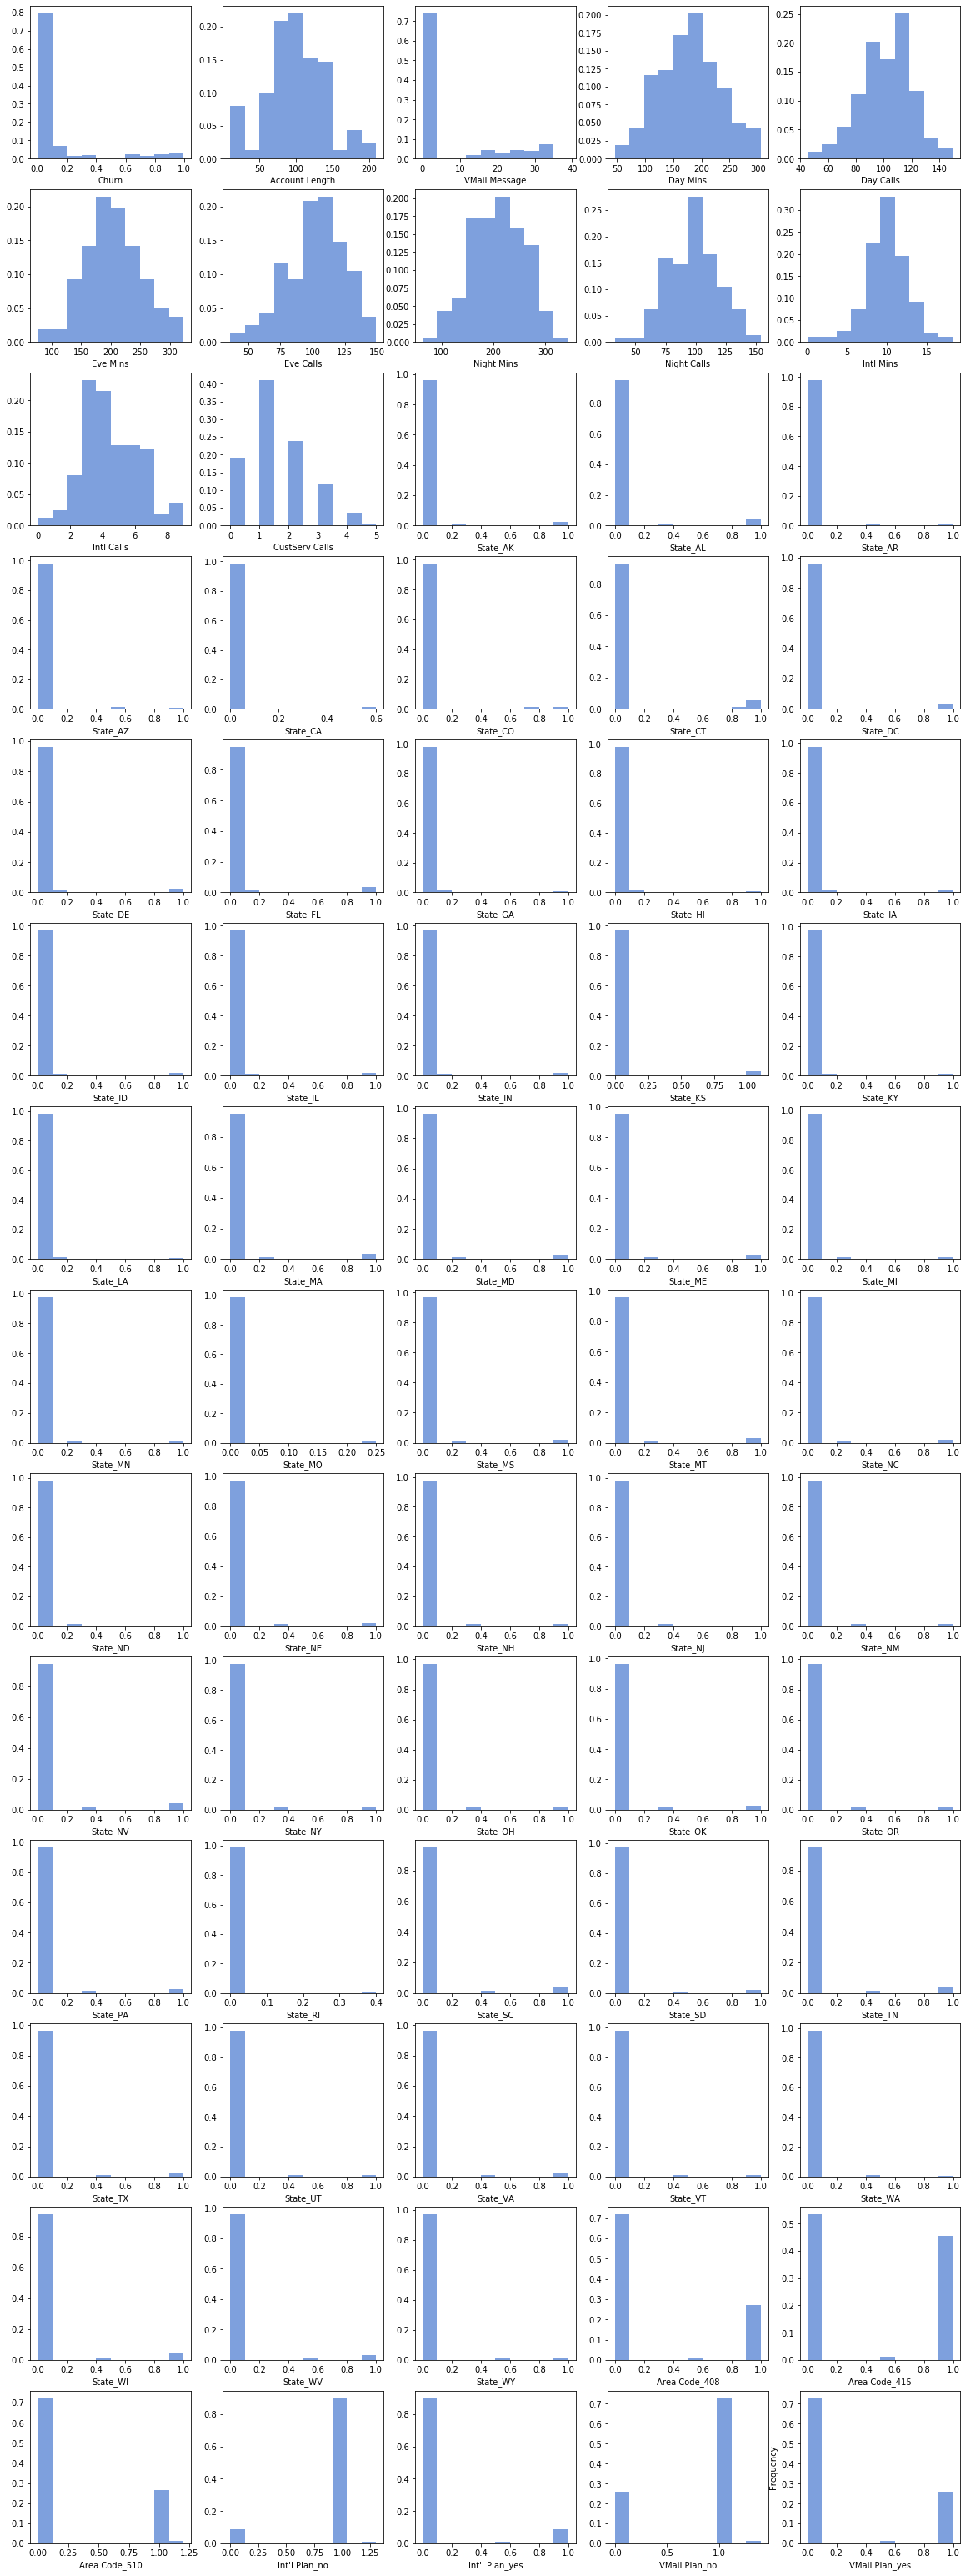

In [43]:
mu.show_distributions(features)

### Execution Stats vs Baseline

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,163,0,0.115871,18.887011,0.239530,0.002989,0.993593
Account Length,163,0,99.693252,16250.000000,40.385312,10.000000,209.000000
VMail Message,163,0,6.657669,1085.200000,11.912801,0.000000,39.000000
Day Mins,163,0,179.149693,29201.400000,53.889285,46.500000,305.200000
Day Calls,163,0,101.515337,16547.000000,18.735274,45.000000,150.000000
Eve Mins,163,0,205.504294,33497.200000,49.268278,76.400000,323.200000
Eve Calls,163,0,102.024540,16630.000000,22.205386,36.000000,149.000000
Night Mins,163,0,208.134969,33926.000000,51.300934,63.600000,344.300000
Night Calls,163,0,98.282209,16020.000000,20.100212,33.000000,154.000000
Intl Mins,163,0,9.876687,1609.900000,2.765288,0.000000,18.300000


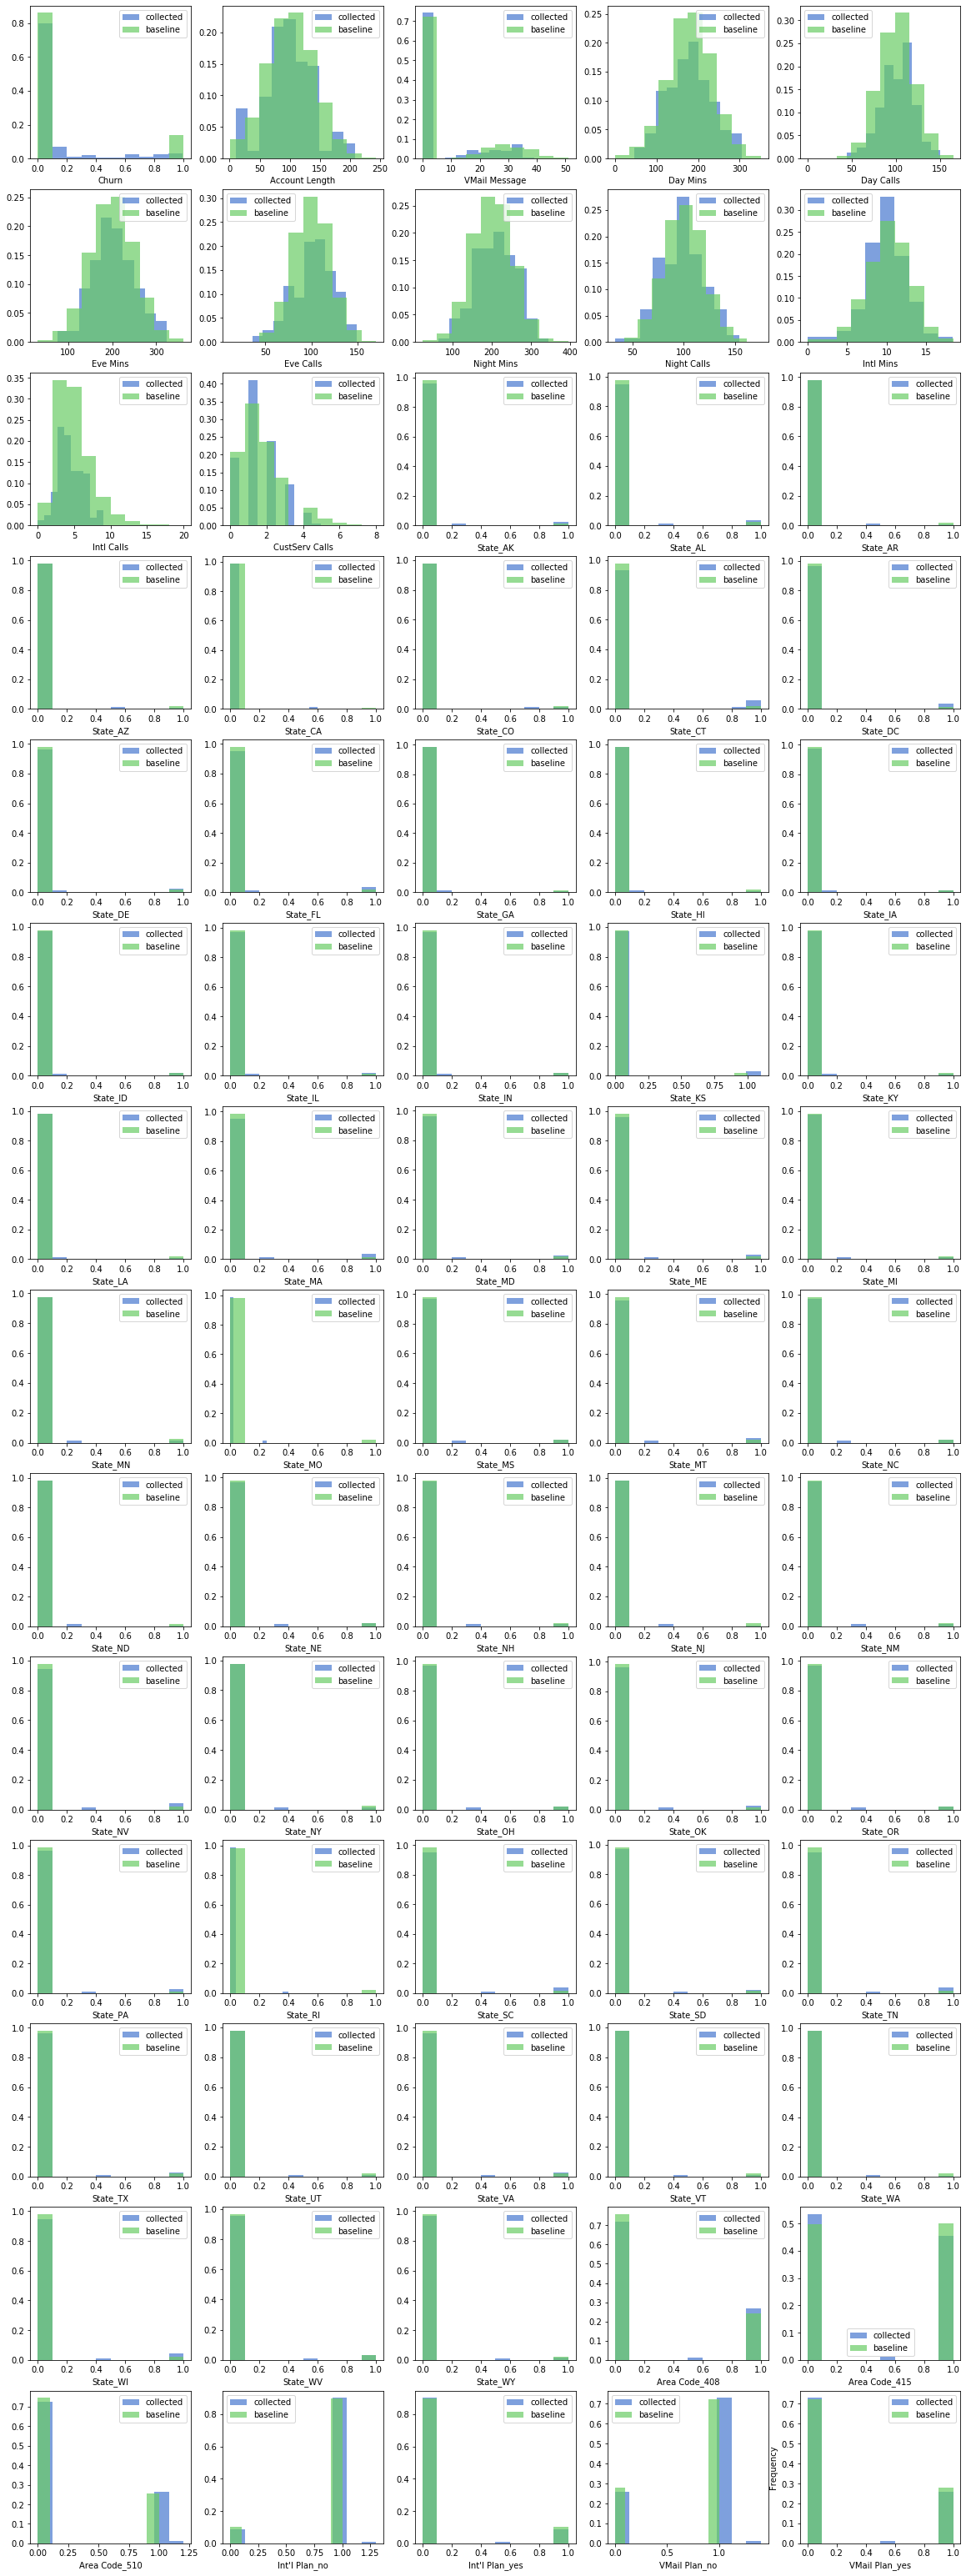

In [44]:
mu.show_distributions(features, feature_baselines)

In [45]:
sagemaker_session.delete_monitoring_schedule(mon_schedule_name)


Deleting Monitoring Schedule with name: xgb-churn-model-schedule-2020-08-14-12-48-42


In [46]:
sagemaker_session.delete_endpoint(churn_model.endpoint_name)

In [ ]:
sagemaker_session.delete_model(churn_model.name)